In [1]:
import tensorflow as tf
import os
import numpy as np
import cv2
from tensorflow.keras.applications.inception_v3 import preprocess_input
from keras_preprocessing import image
import pandas as pd
from tqdm import tqdm
from threading import Thread
import seaborn as sns


current_path = os.path.join(os.getcwd(), '..')
base_path = f'{current_path}/data/raw/cats_and_dogs_filtered'
train_path = os.path.join(f'{base_path}/train/')
validation_path = os.path.join(f'{base_path}/validation/')

try:
    os.mkdir(f'{current_path}/data/processed')
except Exception:
    pass

In [2]:
# (train / validation)
dogs_dataset = (os.path.join(train_path, 'dogs'),
                os.path.join(validation_path, 'dogs'))
cats_dataset = (os.path.join(train_path, 'cats'),
                os.path.join(validation_path, 'cats'))



In [3]:
# Create the base model from the pre-trained model MobileNet V2
model = tf.keras.applications.Xception(include_top=False,
                                        weights='imagenet',
                                        pooling='avg')


In [4]:
def extract_features(img_dir):
    img = cv2.imread(img_dir)
    img = cv2.resize(img, (299, 299))
    xd = image.img_to_array(img) 
    xd = np.expand_dims(xd, axis=0)
    xd = preprocess_input(xd)
    return model.predict(xd)


def extract_data(dataset):
    features = []
    for img_path in tqdm(os.listdir(dataset)):
        img_dir = os.path.join(dataset, img_path)
        features.append(np.append([img_dir], extract_features(img_dir)))
    return features

In [5]:
# def generate_train_dataset():
train_dataset = pd.concat([pd.DataFrame(x) for x in [
    extract_data(dogs_dataset[0]),
    extract_data(cats_dataset[0])
]])

# def generate_validation_dataset():    
validation_dataset = pd.concat([pd.DataFrame(x) for x in [
    extract_data(dogs_dataset[1]),
    extract_data(cats_dataset[1])
]])
    
    
# train_thread = Thread(target=generate_train_dataset)
# validation_thread = Thread(target=generate_validation_dataset)
# for thread in [train_thread, validation_thread]:
#     thread.start()
#     thread.join()
# print("Generated")

100%|██████████| 500/500 [06:01<00:00,  1.38it/s]


In [11]:
train_dataset.to_csv(os.path.join(
    current_path, 'data/processed/train_X.csv'
), header=False, index=False, sep=';')


validation_dataset.to_csv(os.path.join(
    current_path, 'data/processed/validation_X.csv'
), header=False, index=False, sep=';')


In [12]:
train_Y_df = pd.DataFrame('cat' if 'cat.' in Y else 'dog' for Y in train_dataset.loc[:, 0])
validation_Y_df = pd.DataFrame('cat' if 'cat.' in Y else 'dog' for Y in validation_dataset.loc[:, 0])

train_Y_df.to_csv(os.path.join(
    current_path, 'data/processed/train_Y.csv'
), header=False, index=False, sep=';')


validation_Y_df.to_csv(os.path.join(
    current_path, 'data/processed/validation_Y.csv'
), header=False, index=False, sep=';')



In [8]:
from sklearn.manifold.t_sne import TSNE
import matplotlib.pyplot as plt

def visualizate_data(X, y):
    x_tsne = TSNE(n_components=2).fit_transform(X)

    y_aux = pd.DataFrame()
    y_aux['classes'] = y[0]

    tsne_df = pd.DataFrame()
    tsne_df['tsne-x'] = x_tsne[:, 0]
    tsne_df['tsne-y'] = x_tsne[:, 1]
    tsne_df = pd.concat([tsne_df, y_aux], axis=1)

    plt.figure(figsize=(16, 10))
    sns.scatterplot('tsne-x', 'tsne-y',
                    hue="classes",
                    legend='full',
                    palette=sns.color_palette("hls", 2),
                    alpha=0.3,
                    data=tsne_df)
    plt.show()

/Users/lucaspaim/PycharmProjects/deep_learning_cats_dogs/venv/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.manifold.t_sne module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.manifold. Anything that cannot be imported from sklearn.manifold is now part of the private API.
  warnings.warn(message, FutureWarning)


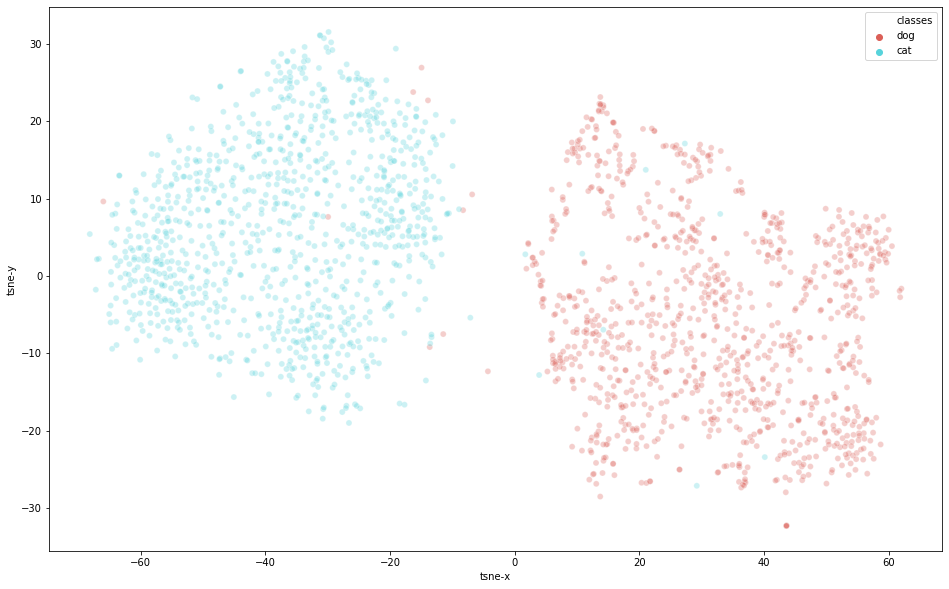

In [9]:
visualizate_data(train_dataset.iloc[:, 1:],
                train_Y_df.iloc[:, 0:])

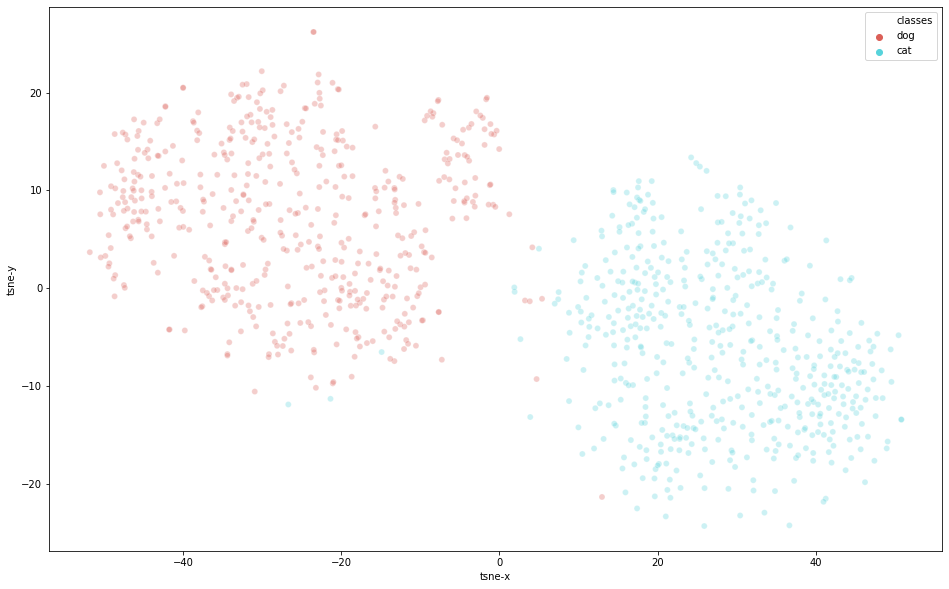

In [10]:
visualizate_data(validation_dataset.iloc[:, 1:],
                 validation_Y_df.iloc[:, 0:])
